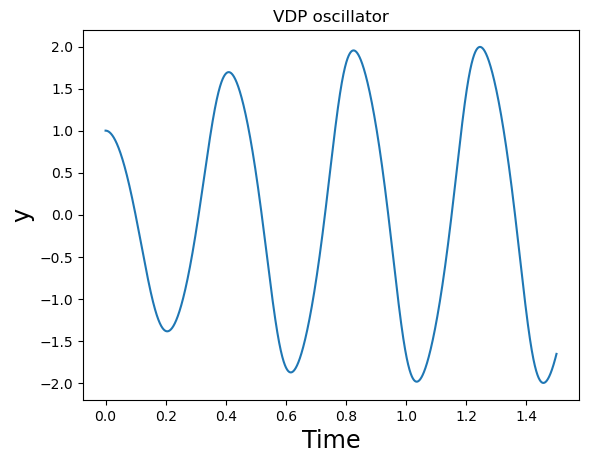

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.integrate import odeint

# def oscillator_model(t):
#     def vdp(y, t, k1=15, k2=1):
#         dxdt = [y[1] , k1*k2*(1-(y[0]**2))*y[1] - k1*k1*y[0]]
#         return dxdt
    
#     y0 = [1, 0]
#     return odeint(vdp, y0, t)

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# x = np.linspace(0, 1.5, 1000)[:, None]
# y = oscillator_model(np.ravel(x))
# y = y[:, 0]

# x = torch.from_numpy(x).float()
# y = torch.from_numpy(y).float()

# x_data = x[0:1500:100].clone().detach()
# y_data = y[0:1500:100].clone().detach()

# plt.figure(figsize=(7, 4))
# plt.plot(x, y, label="Exact solution")
# plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
# plt.legend()
# plt.show()


def runge_kutta4(func, r, t, omega, nu, h):
    """ 
    Runge-Kutta 4 method for solving 1st order differential equations
    
    Usage: xNew = rk4(func, r, t, h) 
    
    Given a function  f(x, t, h) = dx/dt and initial starting 
    conditions for x, rk4() returns the next values of x. 
    func:  user defined function for the 1st order differential equations
    r: dependent variable(s)
    t: independent variable(s)
    h: independent variable step value
    """
    k1 = h*func(r, t, omega, nu)
    k2 = h*func(r+0.5*k1, t+0.5*h, omega, nu)
    k3 = h*func(r+0.5*k2, t+0.5*h, omega, nu)
    k4 = h*func(r+k3, t+h, omega, nu)
    return (k1 + 2*k2 + 2*k3 + k4)/6
   
def pendule_Function(r, t, omega, nu):
    """ vectorized function for the pendule """
    x = r[0]
    v = r[1]
    fx = v
    fv = -omega**2 * x  +  nu*(1 - x**2)*v
    return np.array([fx,fv], float)

nSteps=10000
w0 = 15.
nu=5.

tMin,tMax = 0.0,1.5
tStep = (tMax-tMin)/nSteps

tPoints = np.arange(tMin, tMax, tStep)
xPoints,vPoints = [],[]

x0,v0 = 1.,0.
r = np.array([x0,v0], float)

for t in tPoints:
    xPoints += [r[0]]
    vPoints += [r[1]]
    r += runge_kutta4(pendule_Function, r, t, w0, nu, tStep)

fig1 = plt.figure(1)
plt.plot(tPoints, xPoints)
plt.xlabel("t")
plt.ylabel("x")
plt.xlabel("Time",fontsize="xx-large")
plt.ylabel("y",fontsize="xx-large")
plt.title("VDP oscillator")

x=torch.Tensor(tPoints).view(-1,1)
y=torch.Tensor(xPoints).view(-1,1)

x = x[::10]
y = y[::10, :]

x_data=x[0:210:70]
y_data=y[0:210:70]

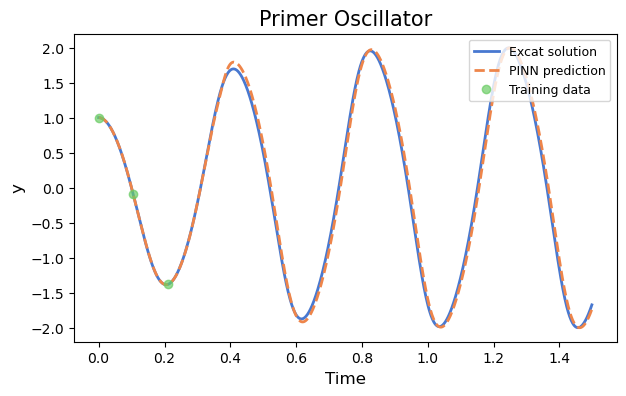

In [2]:
import seaborn as sns

x_physics = torch.linspace(0.,1.5,48).view(-1,1).requires_grad_(True)
ww = w0
torch.manual_seed(123)
model = FCN(1,1,32,3)

optimizer = torch.optim.Adam(model.parameters(),lr=7e-4)
files = []
loss1_history = []
loss2_history = []
loss_history = []
mse_history = []

for i in range(24000):
    optimizer.zero_grad()
    
    yh = model(x_data)
    loss1 = 1*torch.mean((yh-y_data)**2)

    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2   
    physics= (dx2 + ww**2*yhp - nu*(1 - yhp*yhp)*dx)
    loss2 = (1e-4)*torch.mean(physics**2) *1

    yhpp=model(x)
    mse=torch.mean((yhpp-y)**2)

    loss = loss1 + loss2
    loss.backward()
    optimizer.step()

y_pred = model(x).detach()

palette = sns.color_palette("muted")
plt.figure(figsize=(7, 4))
plt.plot(x, y, '-', color=palette[0], linewidth=2, label='Excat solution')
plt.plot(x, y_pred, '--', color=palette[1], linewidth=2, label='PINN prediction')
plt.plot(x_data, y_data, 'o', color=palette[2], linewidth=2, alpha=0.7, label='Training data')
plt.title('Primer Oscillator', fontsize=15, fontweight='medium')
plt.xlabel('Time', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(frameon=True, loc='upper right', fontsize=9)
plt.show()
